In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("redacted.xlsx", index_col='id')
df.sort_index(inplace=True)
df.date = pd.to_datetime(df.date)
df

,date,numbers
id,,
202,2022-01-07,80630
203,2022-01-08,101503
204,2022-01-09,91477
205,2022-01-10,107134
206,2022-01-11,153880
...,...,...
556,2022-12-27,20879
557,2022-12-28,20160
558,2022-12-29,20001


Text(0, 0.5, '# of reported results')

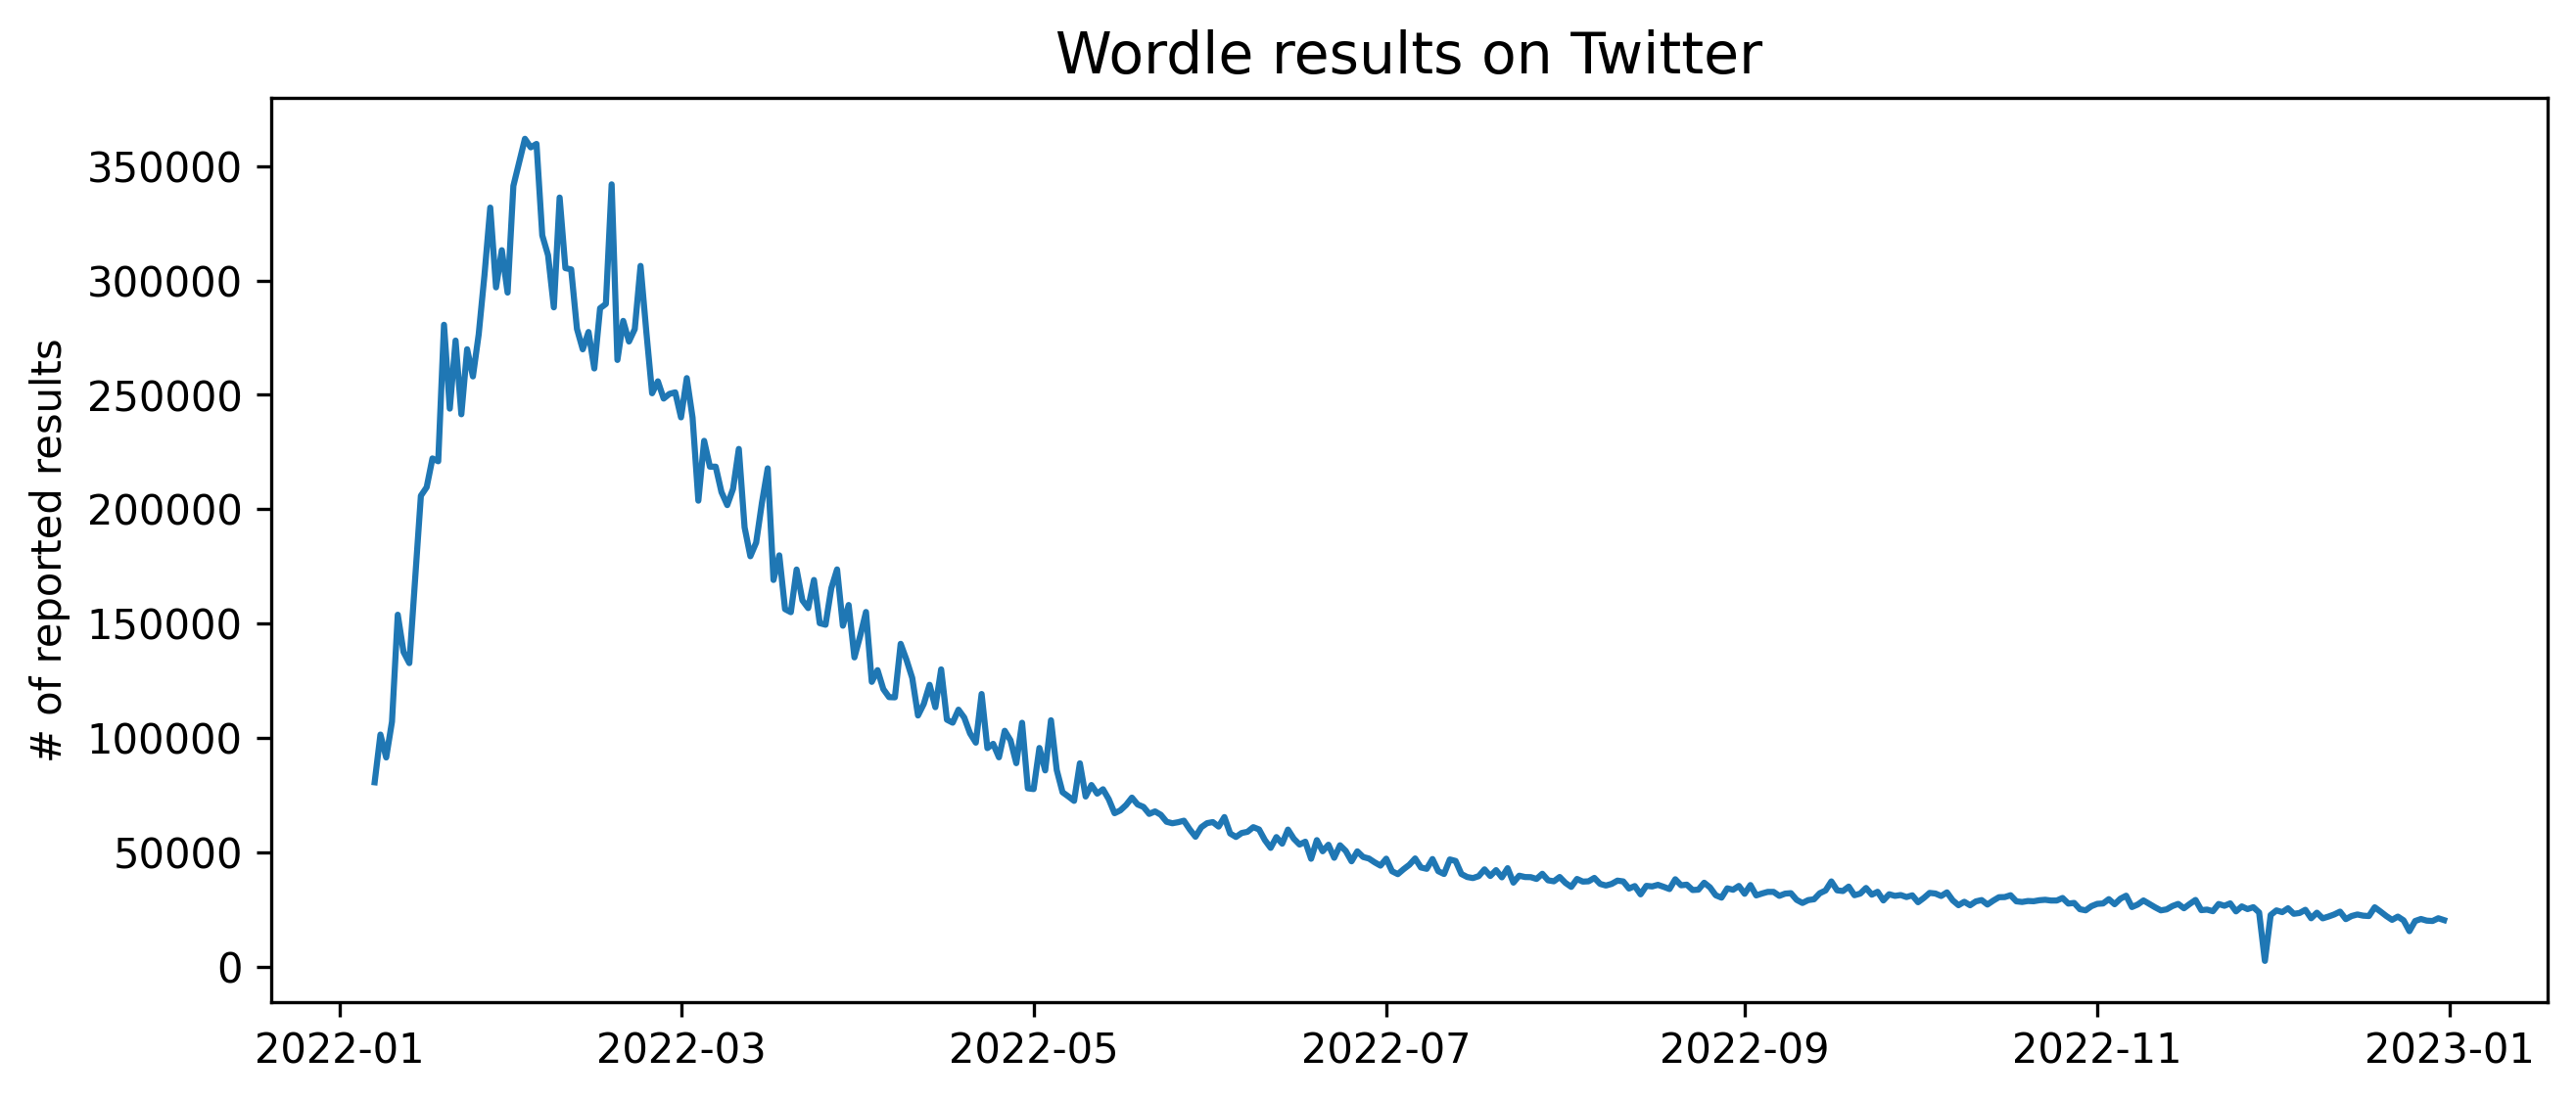

In [3]:
plt.figure(figsize=(10,4), dpi=300)
plt.plot(df.date, df.numbers)
plt.title('Wordle results on Twitter', fontsize=14)
plt.ylabel('# of reported results', fontsize=10)

529显然是异常值，故删去并取前后平均值以平滑

In [4]:
df.loc[529, "numbers"] = (df.loc[530, "numbers"]+df.loc[528, "numbers"])/2
df["numbers.1"] = df.numbers.diff()
df["numbers.2"] = df["numbers.1"].diff()
df

,date,numbers,numbers.1,numbers.2
id,,,,
202,2022-01-07,80630.0,NaN,NaN
203,2022-01-08,101503.0,20873.0,NaN
204,2022-01-09,91477.0,-10026.0,-30899.0
205,2022-01-10,107134.0,15657.0,25683.0
206,2022-01-11,153880.0,46746.0,31089.0
...,...,...,...,...
556,2022-12-27,20879.0,868.0,-3589.0
557,2022-12-28,20160.0,-719.0,-1587.0
558,2022-12-29,20001.0,-159.0,560.0


Text(0, 0.5, 'First order difference of # of reported results')

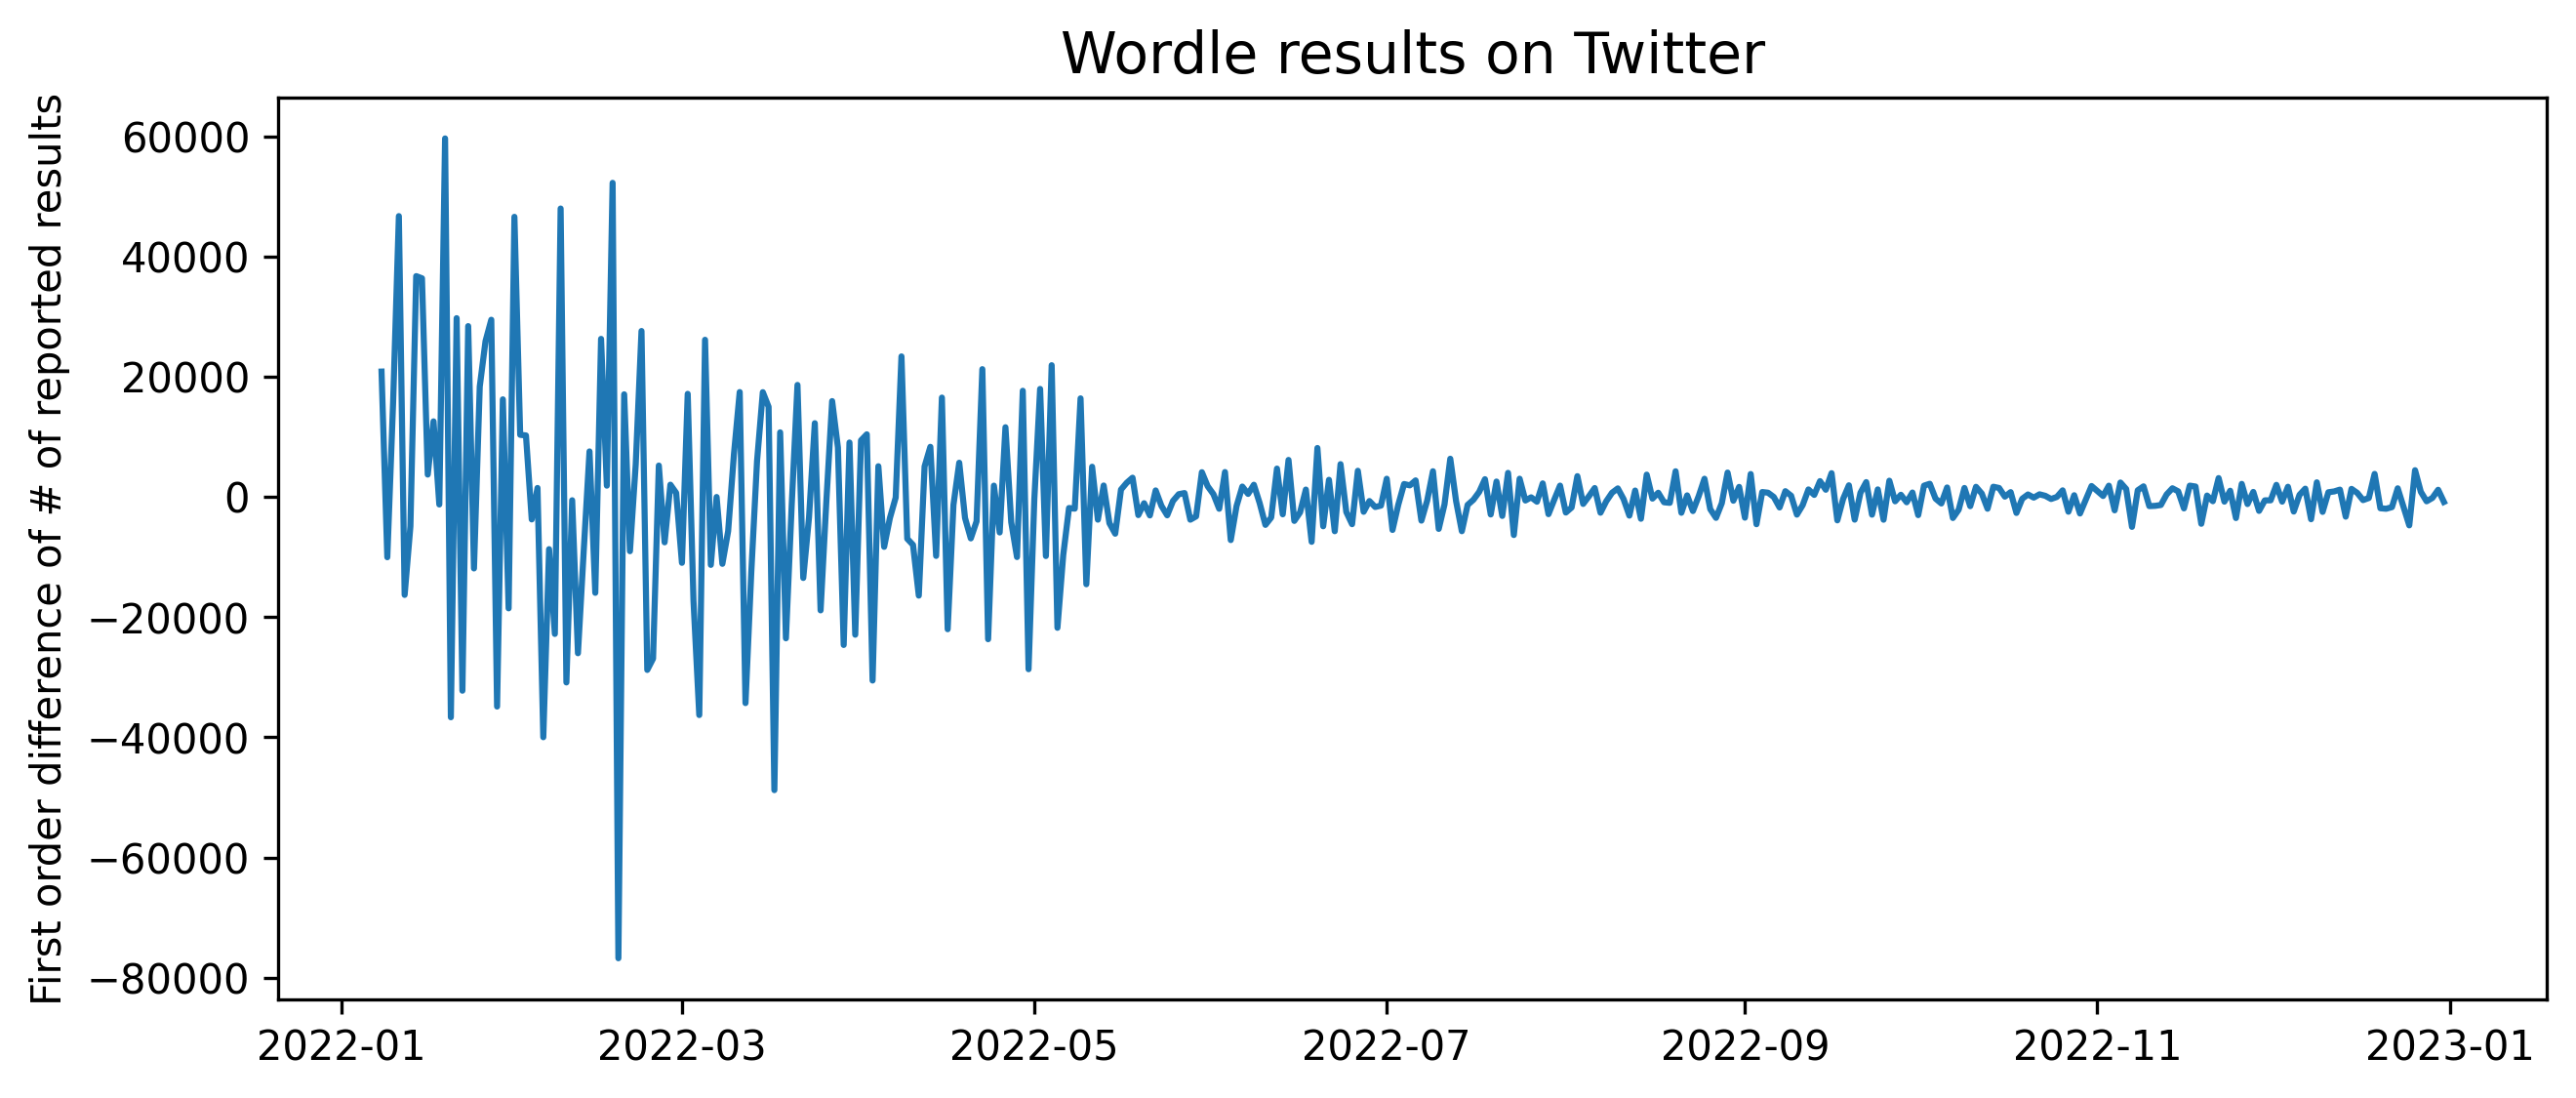

In [5]:
plt.figure(figsize=(10,4), dpi=300)
plt.plot(df.date, df["numbers.1"])
plt.title('Wordle results on Twitter', fontsize=14)
plt.ylabel('First order difference of # of reported results', fontsize=10)

Text(0, 0.5, '# of reported results')

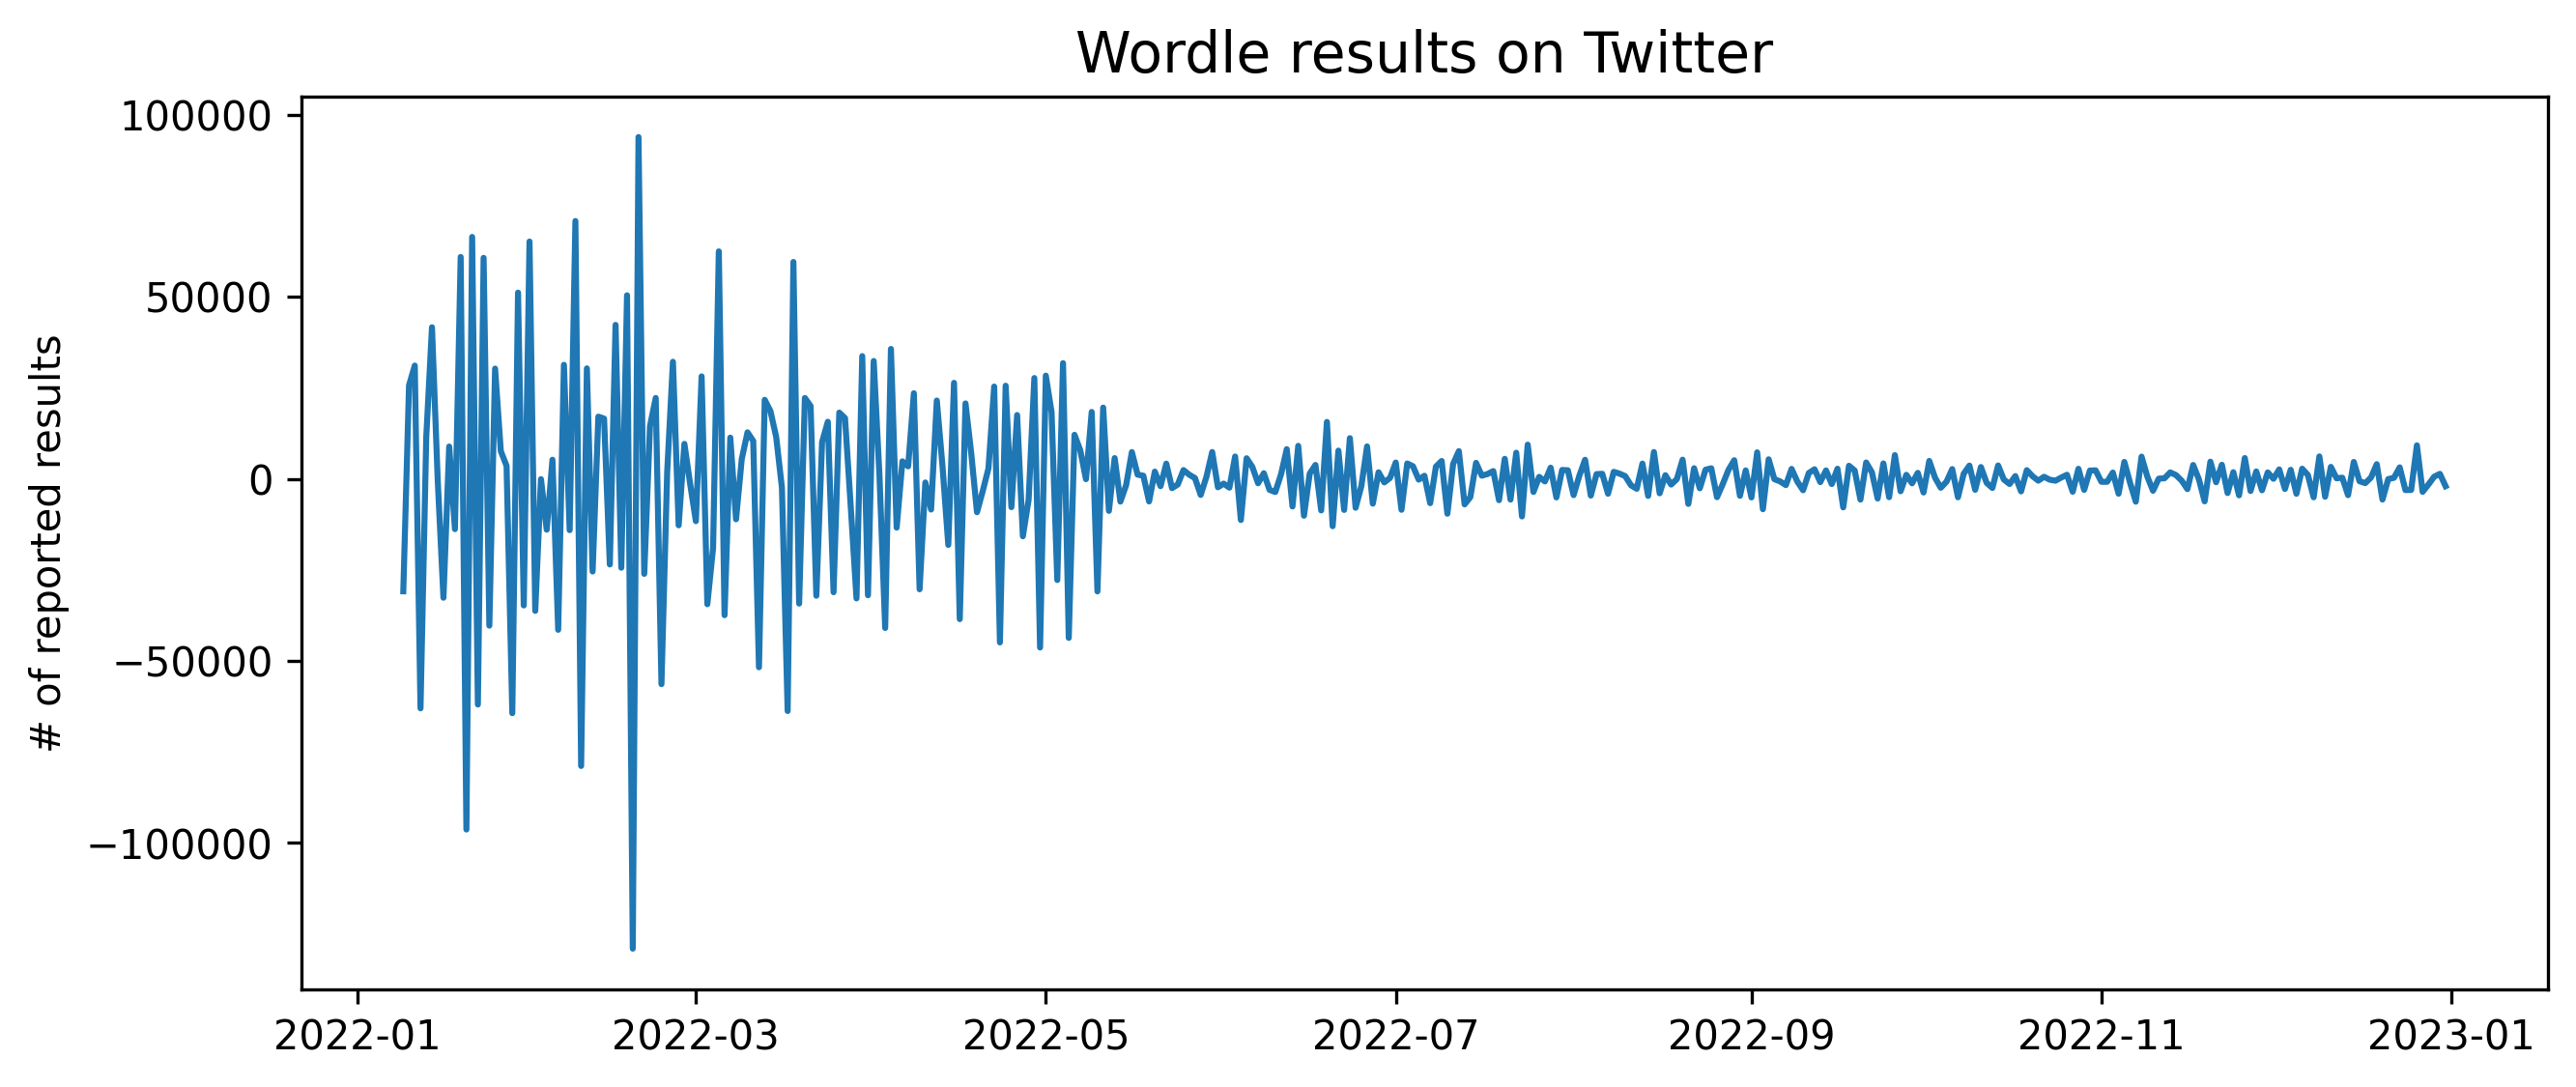

In [6]:
plt.figure(figsize=(10,4), dpi=300)
plt.plot(df.date, df["numbers.2"])
plt.title('Wordle results on Twitter', fontsize=14)
plt.ylabel('# of reported results', fontsize=10)

Text(0, 0.5, 'log # of reported results')

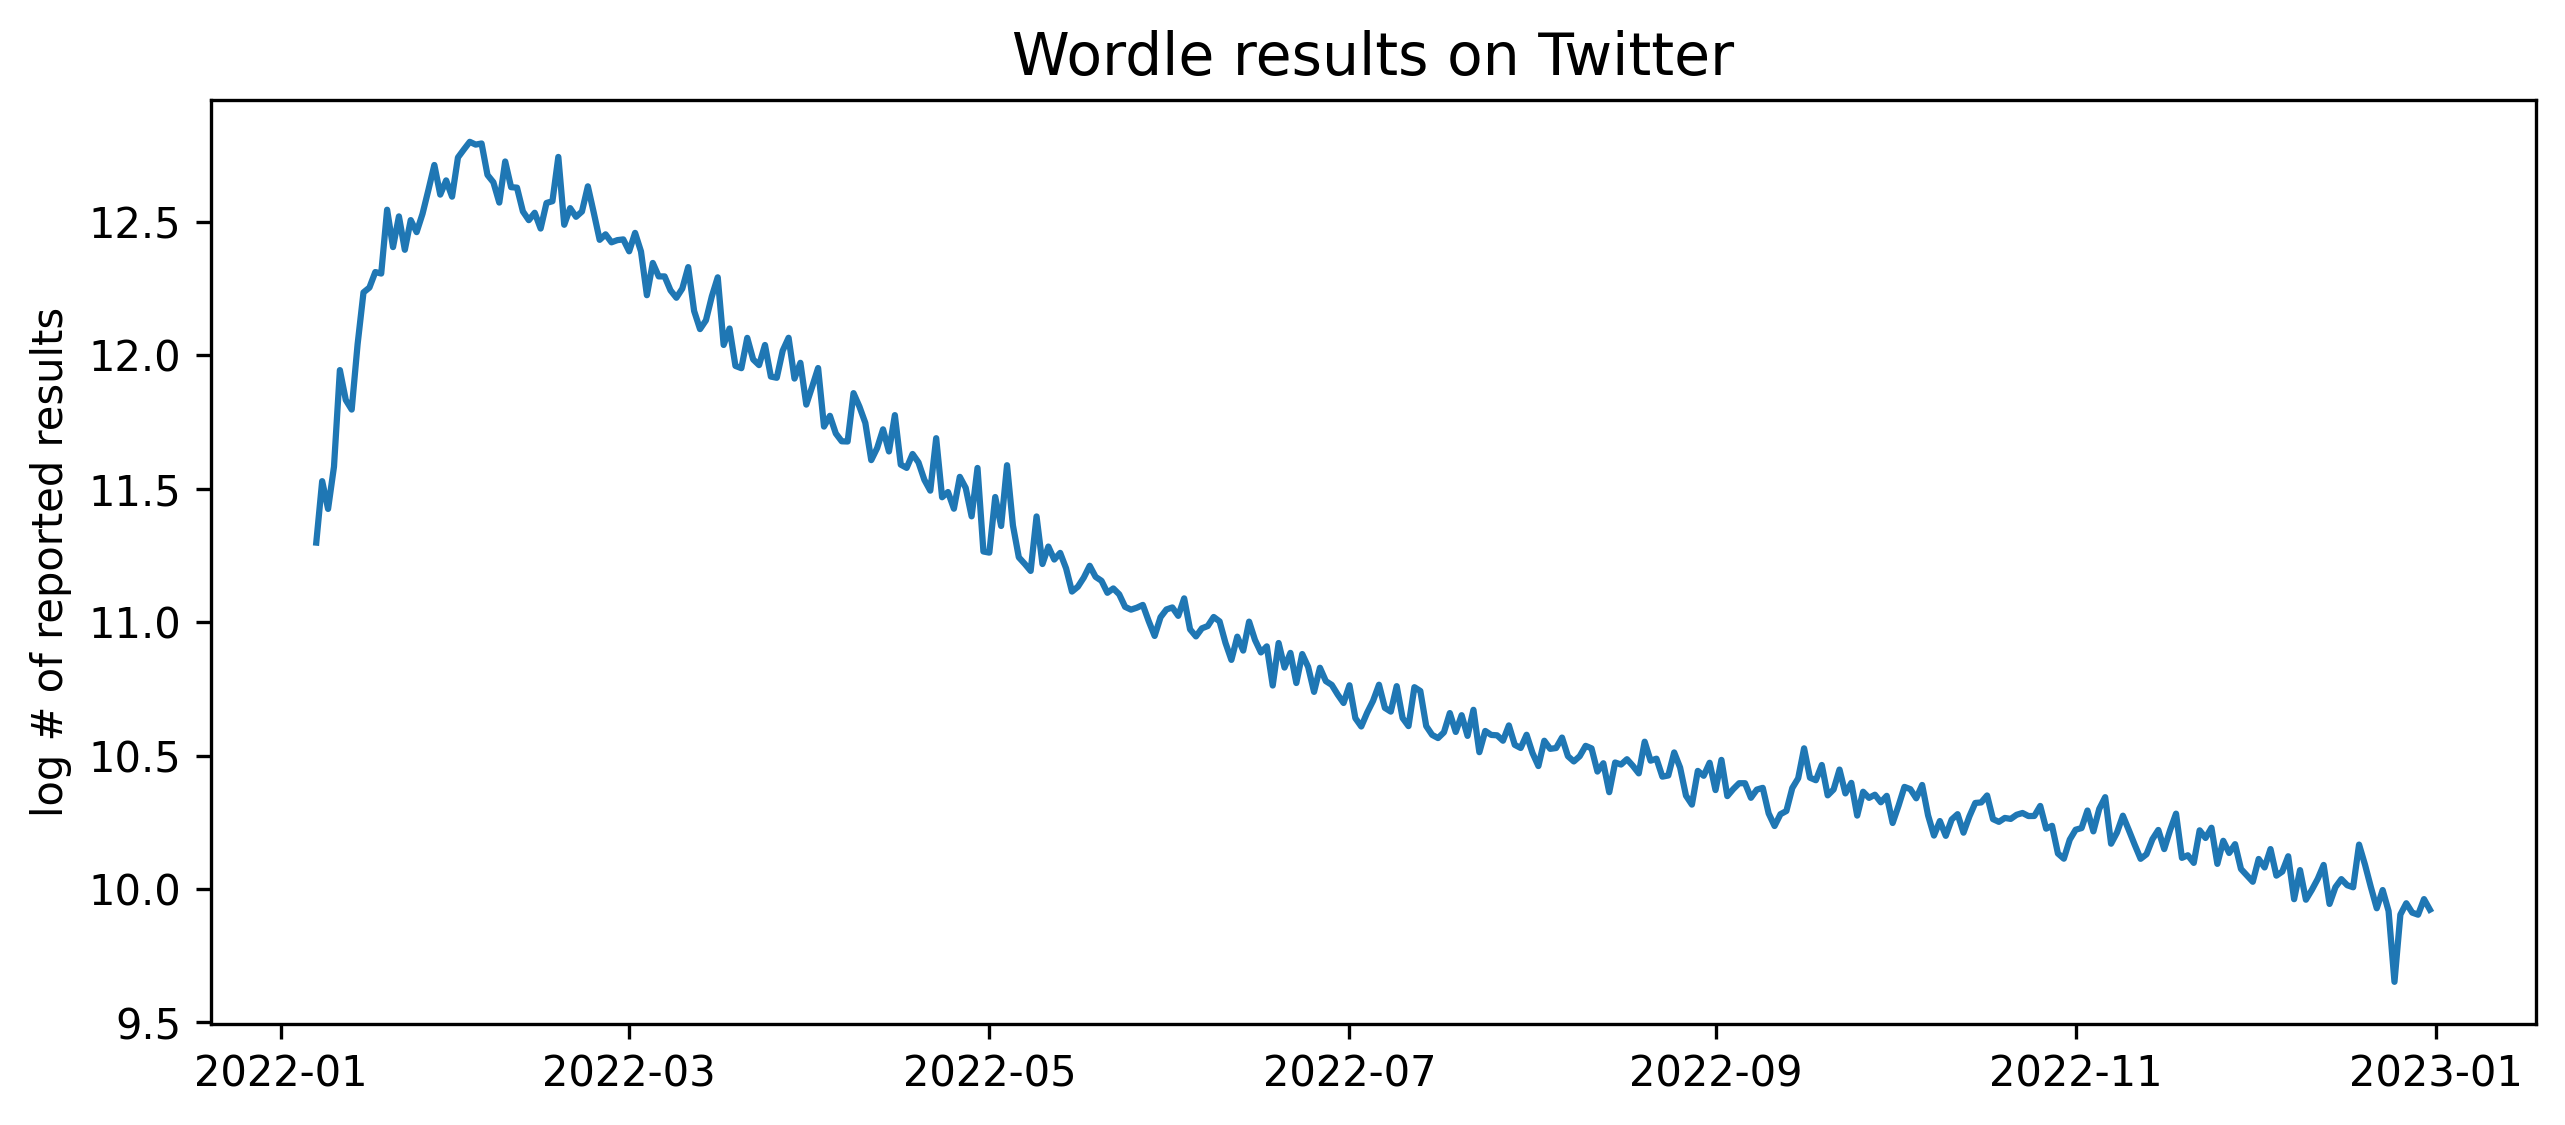

In [7]:
plt.figure(figsize=(10,4), dpi=300)
# plt.plot(df.date[30:], np.log(df.numbers[30:]))
# plt.title('Wordle results on Twitter (Excluding first 30 data pts)', fontsize=14)
plt.plot(df.date, np.log(df.numbers))
plt.title('Wordle results on Twitter', fontsize=14)
plt.ylabel('log # of reported results', fontsize=10)

In [8]:
df["numbers.log"] = np.log(df.numbers)
df["numbers.log.1"] = df["numbers.log"].diff()

Text(0, 0.5, '1st diff of log # of reported results')

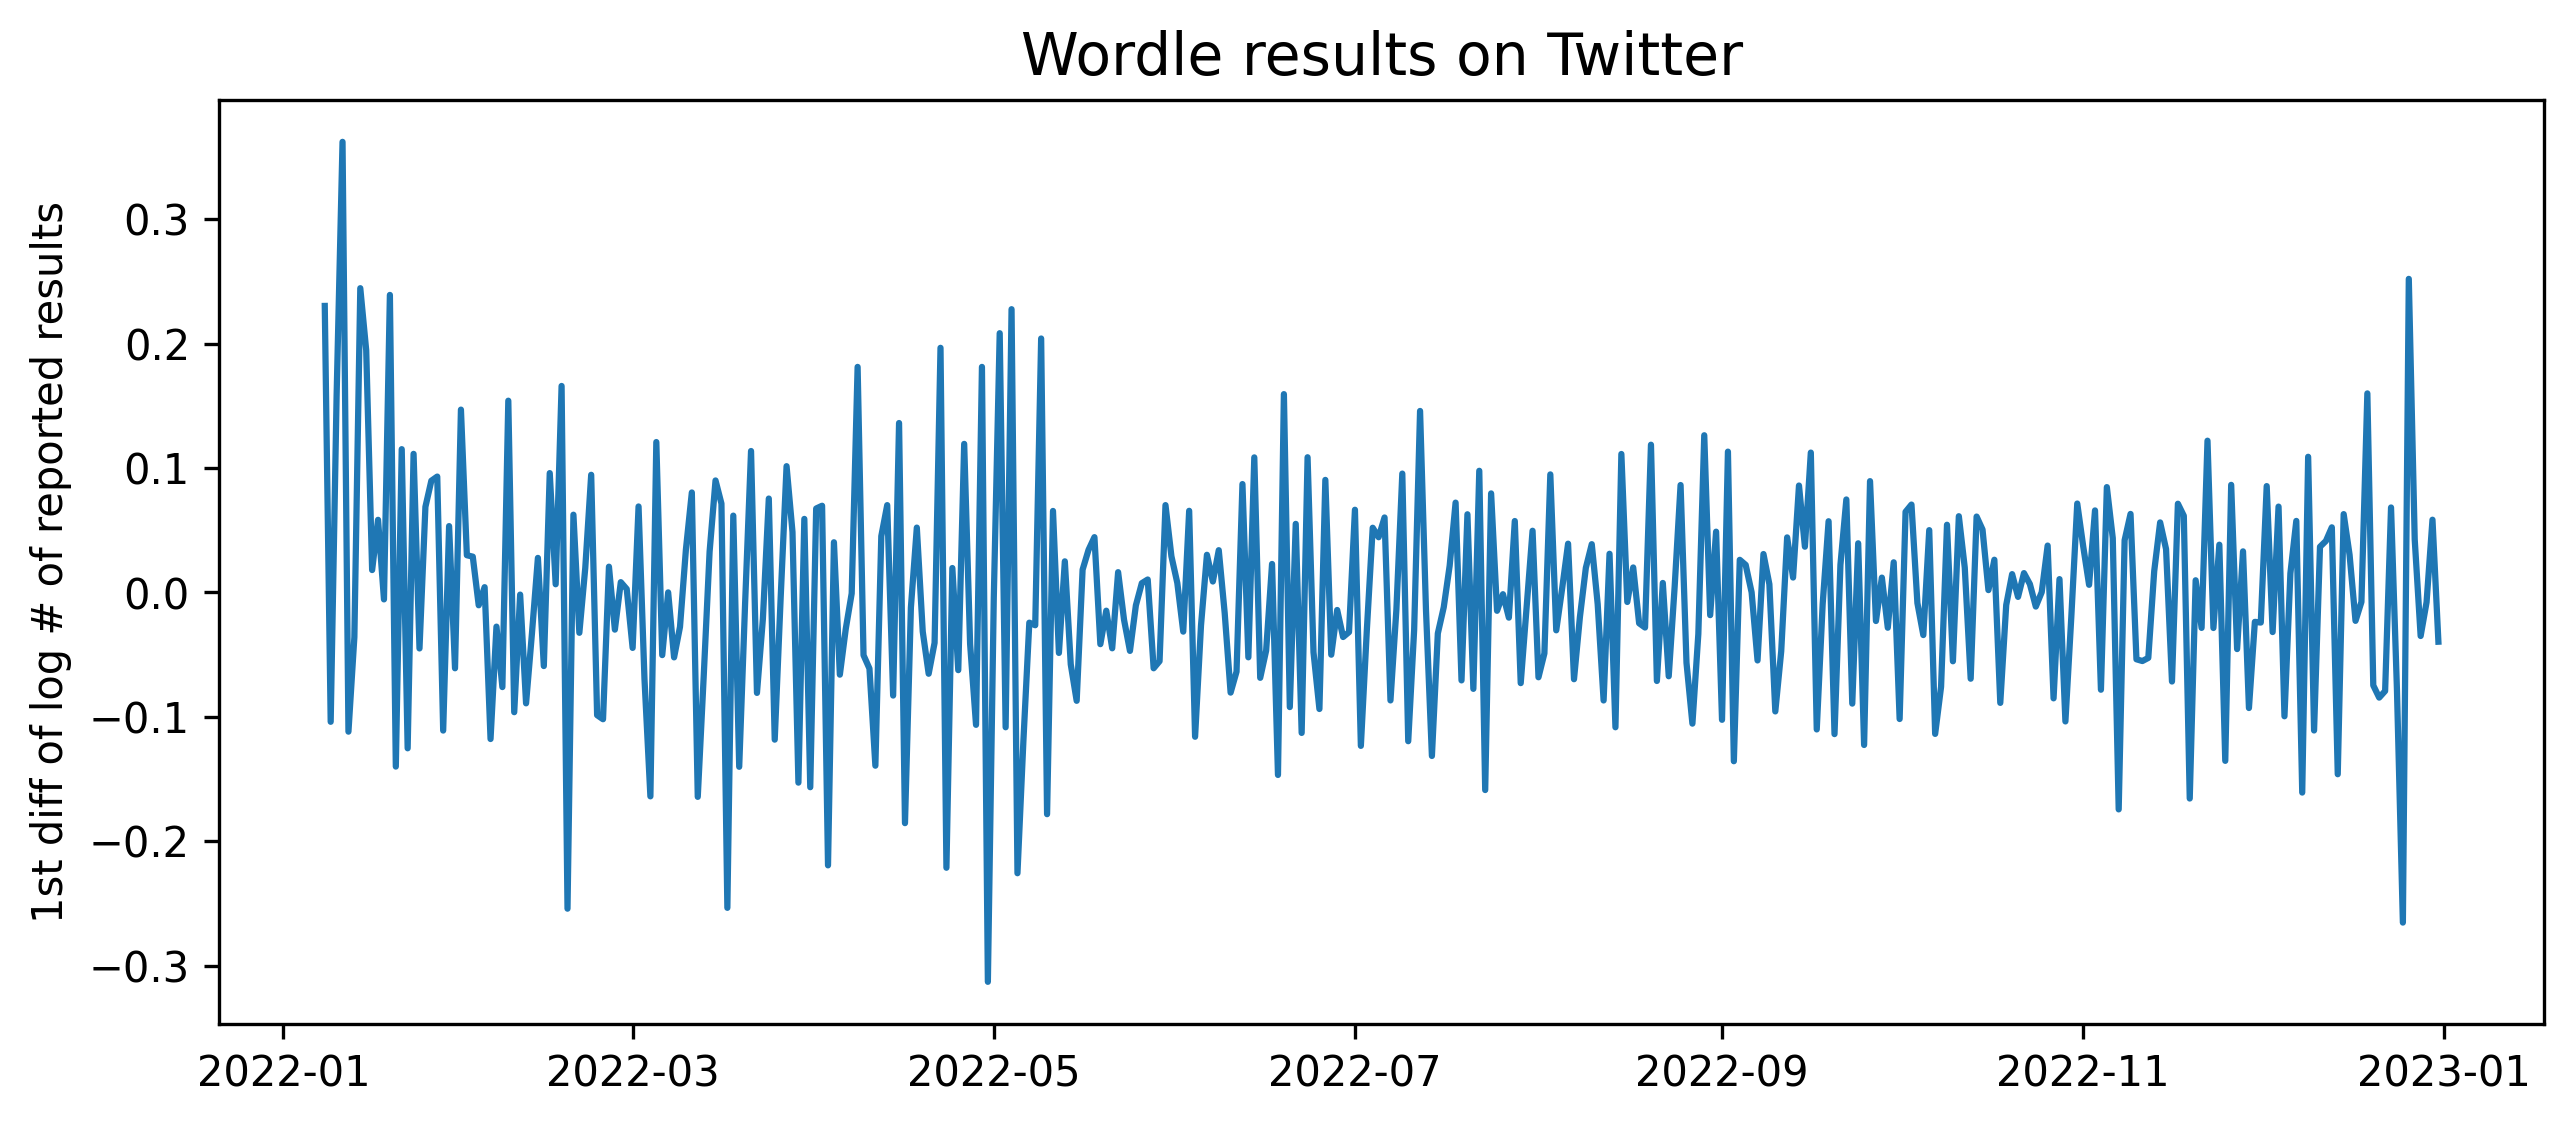

In [9]:
plt.figure(figsize=(10,4), dpi=300)
# plt.plot(df.date[30:], df["numbers.log.1"][30:])
# plt.title('Wordle results on Twitter (Excluding first 30 data pts)', fontsize=14)
plt.plot(df.date, df["numbers.log.1"])
plt.title('Wordle results on Twitter', fontsize=14)
plt.ylabel('1st diff of log # of reported results', fontsize=10)

目标：预测2023.3.1数量，实际为19655

# 取对数差分+ARMA（去除前30天）

In [10]:
df1 = df[["date", "numbers", "numbers.log", "numbers.log.1"]].iloc[30:, :]
df1.index = df1.date
df1

,date,numbers,numbers.log,numbers.log.1
date,,,,
2022-02-06,2022-02-06,311018.0,12.647606,-0.027526
2022-02-07,2022-02-07,288228.0,12.571507,-0.076099
2022-02-08,2022-02-08,336236.0,12.725569,0.154061
2022-02-09,2022-02-09,305372.0,12.629286,-0.096283
2022-02-10,2022-02-10,304830.0,12.627510,-0.001776
...,...,...,...,...
2022-12-27,2022-12-27,20879.0,9.946499,0.042462
2022-12-28,2022-12-28,20160.0,9.911456,-0.035043
2022-12-29,2022-12-29,20001.0,9.903538,-0.007918


In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [12]:
# ADF单位根检验平稳性
from statsmodels.tsa.stattools import adfuller
adfuller(df1["numbers.log.1"])
# 1%显著性下拒绝，确实是平稳的

(-11.642161366769,
 2.1340796627712137e-21,
 5,
 323,
 {'1%': -3.4507587628808922,
  '5%': -2.870530068560499,
  '10%': -2.5715597727381647},
 -753.26647560591)

In [15]:
import plotly.graph_objects as go
import plotly.io as pio
def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,26])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title, 
                     xaxis_title='Lag', 
                     yaxis_title='PACF' if plot_pacf else 'ACF', 
                     font=dict(size=16))
    fig.show()
    pio.write_image(fig, 'pacf.pdf' if plot_pacf else 'acf.pdf',scale=5, width=1000, height=800)

In [16]:
create_corr_plot(df1["numbers.log.1"])
create_corr_plot(df1["numbers.log.1"], plot_pacf=True)

In [17]:
from tqdm import trange

In [18]:
pmax = 10
qmax = 10
bic_matrix = []  # BIC矩阵

for p in trange(pmax):
    tmp = []
    for q in range(qmax):
        try:
            tmp.append(ARIMA(df1["numbers.log"], order=(p, 1, q)).fit().bic)
        except Exception as e:
            print(e)
            tmp.append(None)
    bic_matrix.append(tmp)

bic_matrix = pd.DataFrame(bic_matrix)
p, q = bic_matrix.stack().idxmin()
print(u'BIC最小的p值和q值为：%s、%s' % (p, q))

100%|█████████████████████████████████████████████| 10/10 [00:32<00:00,  3.25s/it]

BIC最小的p值和q值为：2、3


根据ACF/PACF图以及结合BIC方法最终定阶为$\log{X_t}\sim ARIMA(2,1,3)$

In [19]:
model = ARIMA(df1["numbers.log"], order=(2,1,3)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            numbers.log   No. Observations:                  329
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 407.092
Date:                Wed, 08 May 2024   AIC                           -802.183
Time:                        20:21:57   BIC                           -779.425
Sample:                    02-06-2022   HQIC                          -793.103
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1308      0.118      1.111      0.267      -0.100       0.362
ar.L2          0.8645      0.118      7.320      0.000       0.633       1.096
ma.L1         -0.9392      0.102     -9.211      0.000      -1.139      -0.739
ma.L2         -0.8409      0.170     -4.960      0.000      -1.173      -0.509
ma.L3          0.7959      0.079     10.022      0.000       0.640       0.952
sigma2         0.0048      0.000     15.050      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   3.26   Jarque-Bera (JB):                17.20
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.01
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

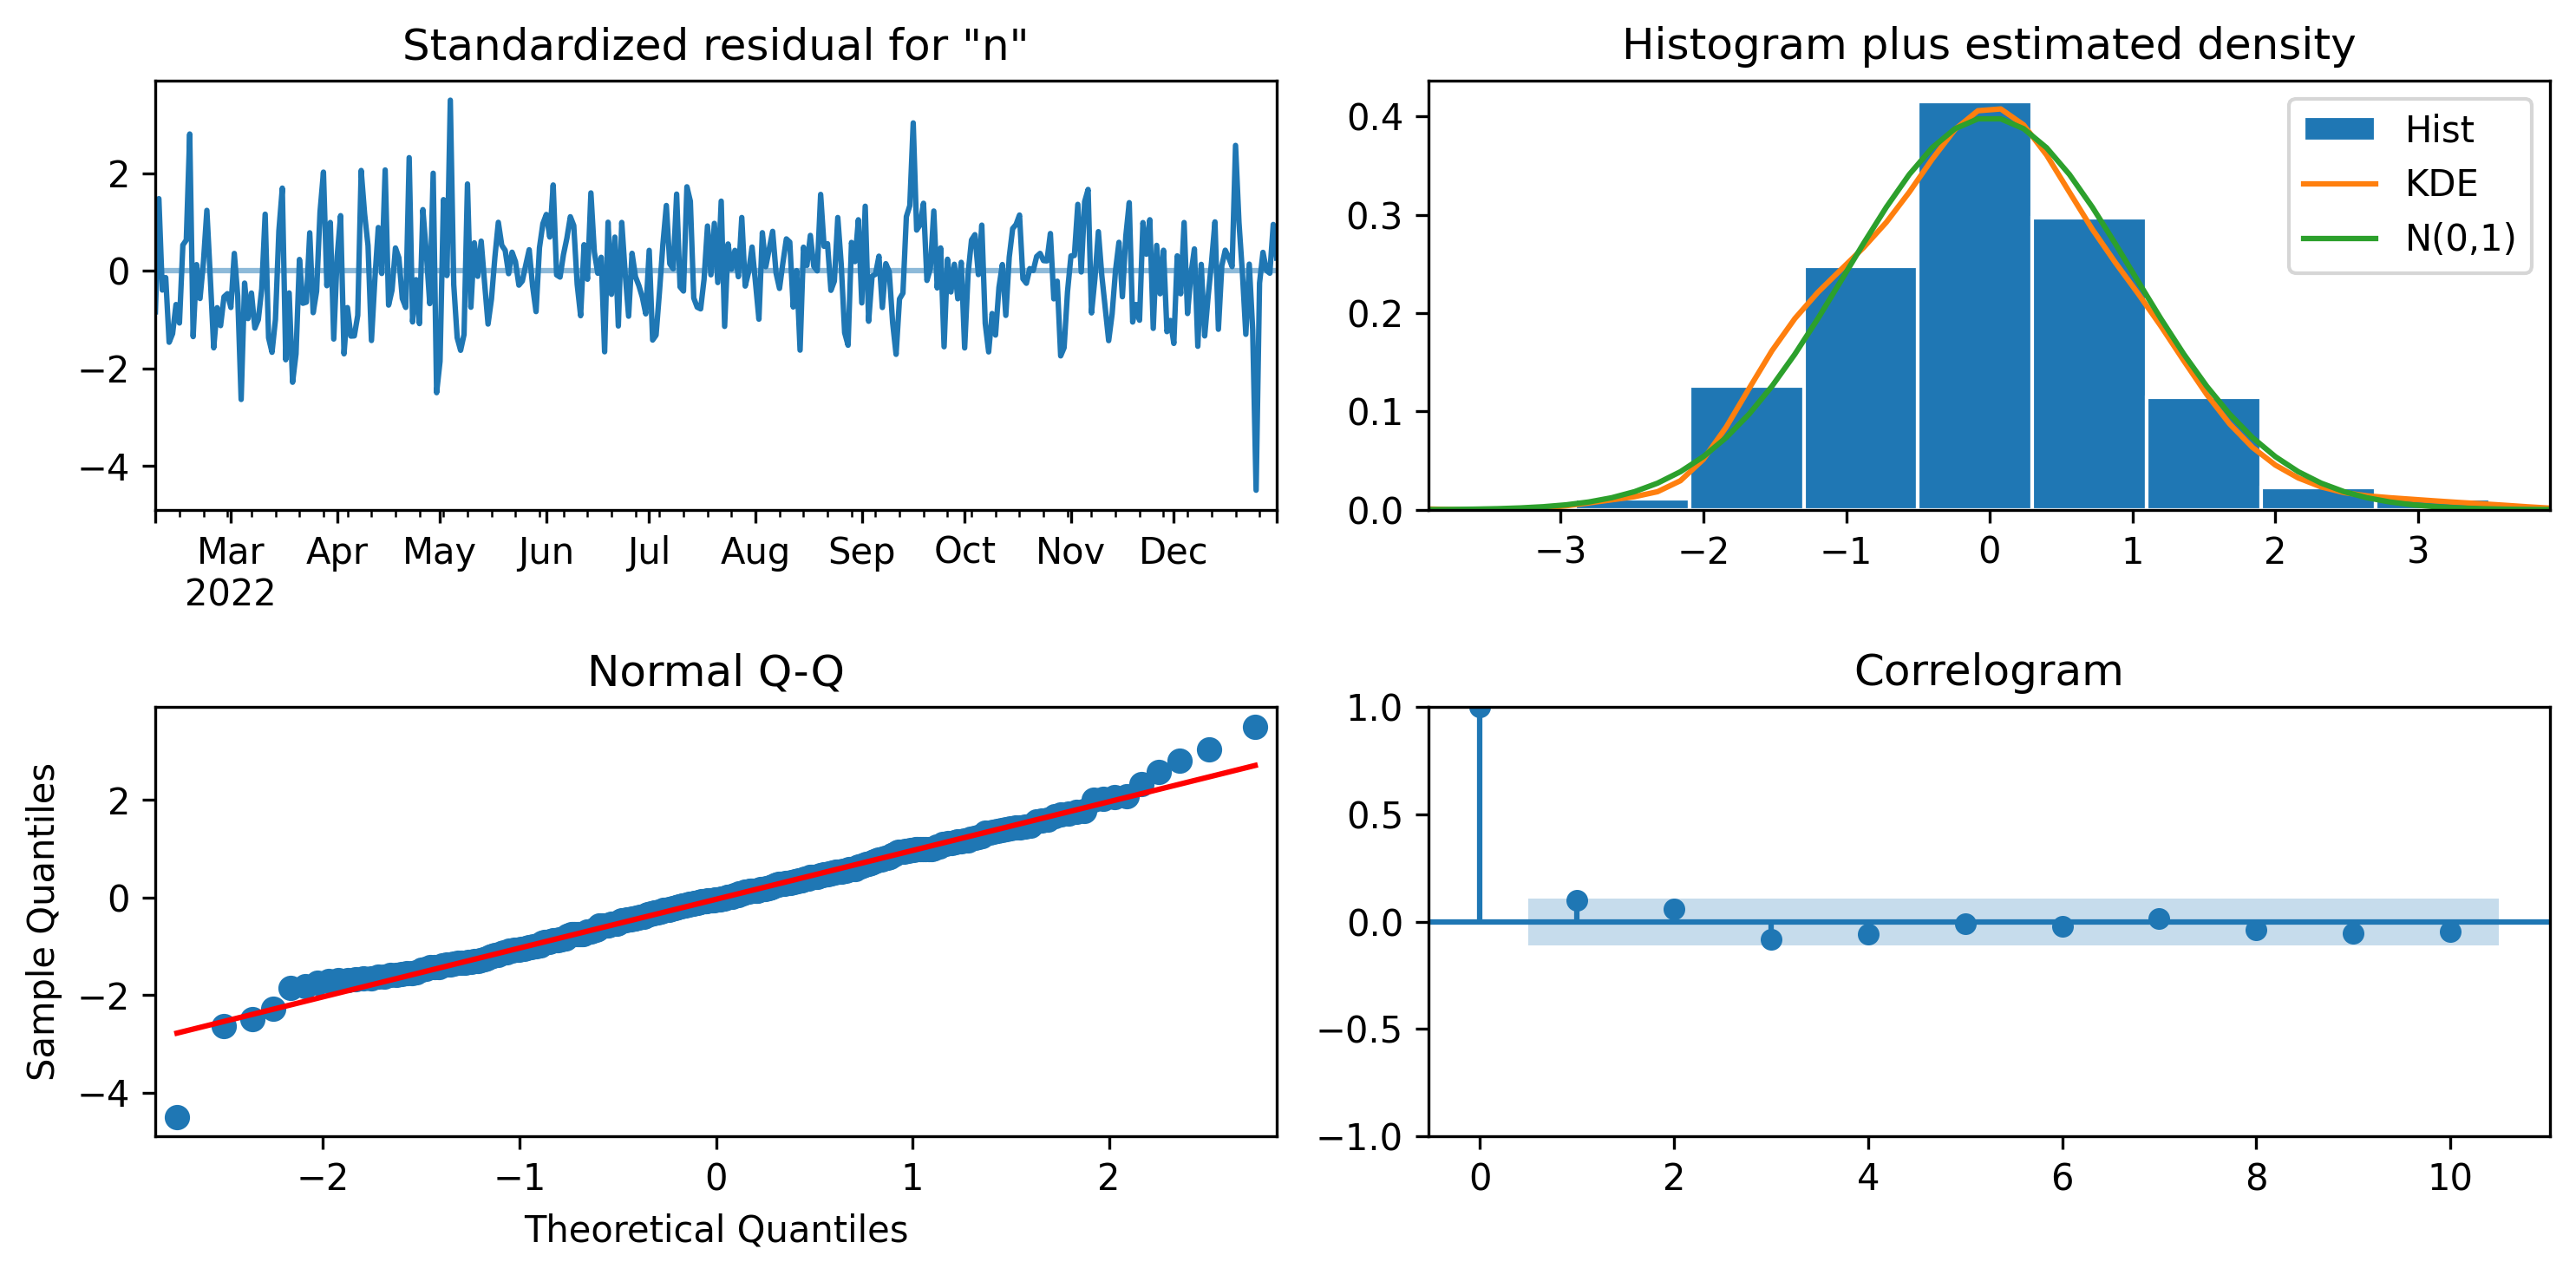

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), dpi=300)
axes = ax.flatten()
from statsmodels.graphics.utils import _import_mpl, create_mpl_fig

variable=0
lags=10
truncate_endog_names=24
auto_ylims=False
bartlett_confint=False
acf_kwargs=None
        
d = np.maximum(model.loglikelihood_burn, model.nobs_diffuse)
if hasattr(model.data, 'dates') and model.data.dates is not None:
    ix = model.data.dates[d:]
else:
    ix = np.arange(model.nobs - d)
resid = pd.Series(
    model.filter_results.standardized_forecasts_error[variable, d:],
    index=ix)

# Top-left: residuals vs time
ax = axes[0]
resid.dropna().plot(ax=ax)
ax.hlines(0, ix[0], ix[-1], alpha=0.5)
ax.set_xlim(ix[0], ix[-1])
name = model.model.endog_names[variable]
if len(name) > truncate_endog_names:
    name = name[:truncate_endog_names - 3] + '...'
ax.set_title(f'Standardized residual for "{name}"')

# Top-right: histogram, Gaussian kernel density, Normal density
resid_nonmissing = resid.dropna()
ax = axes[1]
ax.hist(resid_nonmissing, density=True, label='Hist',
        edgecolor='#FFFFFF')

from scipy.stats import gaussian_kde, norm
kde = gaussian_kde(resid_nonmissing)
xlim = (-1.96*2, 1.96*2)
x = np.linspace(xlim[0], xlim[1])
ax.plot(x, kde(x), label='KDE')
ax.plot(x, norm.pdf(x), label='N(0,1)')
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Histogram plus estimated density')

# Bottom-left: QQ plot
ax = axes[2]
from statsmodels.graphics.gofplots import qqplot
qqplot(resid_nonmissing, line='s', ax=ax)
ax.set_title('Normal Q-Q')

# Bottom-right: Correlogram
ax = axes[3]
from statsmodels.graphics.tsaplots import plot_acf

if acf_kwargs is None:
    acf_kwargs = {}
plot_acf(resid, ax=ax, lags=lags, auto_ylims=auto_ylims,
         bartlett_confint=bartlett_confint, **acf_kwargs)
ax.set_title('Correlogram')
plt.tight_layout()

In [21]:
predictions = model.get_prediction(start='2022-02-06', end='2023-03-01')
df1_after = df1.copy()
df1_after = df1_after.reindex(predictions.predicted_mean.index)
df1_after['pred_mean'] = predictions.predicted_mean

df1_after['pred_lower_conf'] = np.exp(predictions.conf_int()["lower numbers.log"])
df1_after['pred_numbers'] = np.exp(df1_after["pred_mean"])
df1_after['pred_upper_conf'] = np.exp(predictions.conf_int()["upper numbers.log"])
df1_after = df1_after[1:]
df1_after

,date,numbers,numbers.log,numbers.log.1,pred_mean,pred_lower_conf,pred_numbers,pred_upper_conf
2022-02-07,2022-02-07,288228.0,12.571507,-0.076099,12.647606,260379.634268,311017.985587,371504.429025
2022-02-08,2022-02-08,336236.0,12.725569,0.154061,12.605425,254318.377775,298171.685658,349586.824617
2022-02-09,2022-02-09,305372.0,12.629286,-0.096283,12.659372,270850.252327,314698.922066,365646.369900
2022-02-10,2022-02-10,304830.0,12.627510,-0.001776,12.637930,265614.588067,308023.082973,357202.593181
2022-02-11,2022-02-11,278826.0,12.538343,-0.089166,12.647762,268656.811281,311066.429033,360170.742777
...,...,...,...,...,...,...,...,...
2023-02-25,NaT,NaN,NaN,NaN,9.550815,9393.503718,14056.148295,21033.185361
2023-02-26,NaT,NaN,NaN,NaN,9.544981,9271.307558,13974.381080,21063.191501
2023-02-27,NaT,NaN,NaN,NaN,9.539166,9150.374706,13893.349600,21094.782377
2023-02-28,NaT,NaN,NaN,NaN,9.533361,9030.651528,13812.940024,21127.746047


In [22]:
dates = df1_after.index
dates

DatetimeIndex(['2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10',
               '2022-02-11', '2022-02-12', '2022-02-13', '2022-02-14',
               '2022-02-15', '2022-02-16',
               ...
               '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23',
               '2023-02-24', '2023-02-25', '2023-02-26', '2023-02-27',
               '2023-02-28', '2023-03-01'],
              dtype='datetime64[ns]', length=388, freq='D')

In [23]:
real = pd.read_excel("real.xlsx")
dates_real = real.date

In [24]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=df1_after.numbers, mode='lines', name='Real data (train)'))
fig.add_trace(go.Scatter(x=dates_real, y=real.numbers, mode='lines', name='Real data (test)'))
fig.add_trace(go.Scatter(x=dates, y=df1_after.pred_numbers, mode='lines', name='ARIMA prediction'))

# # 添加置信区间带
fig.add_trace(
    go.Scatter(
        name='Upper Bound',
        x=dates,
        y=df1_after.pred_upper_conf,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False)
)
fig.add_trace(
    go.Scatter(
        name='Lower Bound',
        x=dates,
        y=df1_after.pred_lower_conf,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
)

fig.update_layout(title='Time Series Plot with Confidence Interval',
                   xaxis_title='Date',
                   yaxis_title='# of reported results', 
                 legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="center",
                    x=0.5,), 
                  font=dict(
                      size=16
                  )
                 )
fig.add_annotation(
    x="2023-03-01",
    y=13733.237856,
    text="Prediction: 13733 / Real: 19655",
    showarrow=True,
    xanchor="right",
)
fig.show()

In [25]:
import plotly.io as pio
pio.write_image(fig, '1.pdf',scale=5, width=1600, height=800)

# 差分+ARMA（自2022.6）

In [26]:
df2 = df[["date", "numbers", "numbers.1"]].iloc[145:, :]
df2

,date,numbers,numbers.1
id,,,
347,2022-06-01,63241.0,473.0
348,2022-06-02,61278.0,-1963.0
349,2022-06-03,65431.0,4153.0
350,2022-06-04,58263.0,-7168.0
351,2022-06-05,56738.0,-1525.0
...,...,...,...
556,2022-12-27,20879.0,868.0
557,2022-12-28,20160.0,-719.0
558,2022-12-29,20001.0,-159.0


In [27]:
create_corr_plot(df2["numbers.1"])
create_corr_plot(df2["numbers.1"], plot_pacf=True)

In [28]:
pmax = 10
qmax = 10
bic_matrix = []  # BIC矩阵

for p in trange(pmax):
    tmp = []
    for q in range(qmax):
        try:
            tmp.append(ARIMA(df2["numbers"], order=(p, 1, q)).fit().bic)
        except Exception as e:
            print(e)
            tmp.append(None)
    bic_matrix.append(tmp)

bic_matrix = pd.DataFrame(bic_matrix)
p, q = bic_matrix.stack().idxmin()
print(u'BIC最小的p值和q值为：%s、%s' % (p, q))

100%|█████████████████████████████████████████████| 10/10 [00:29<00:00,  2.92s/it]

BIC最小的p值和q值为：0、1


In [29]:
# ADF单位根检验平稳性
from statsmodels.tsa.stattools import adfuller
adfuller(df2["numbers.1"])
# 1%显著性下拒绝，确实是平稳的

(-9.25987108937485,
 1.4165858004678333e-15,
 5,
 208,
 {'1%': -3.4621857592784546,
  '5%': -2.875537986778846,
  '10%': -2.574231080806213},
 3596.8776347764647)

In [36]:
model = ARIMA(df2["numbers"], order=(0,1,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                numbers   No. Observations:                  214
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1968.197
Date:                Wed, 08 May 2024   AIC                           3940.394
Time:                        20:30:37   BIC                           3947.117
Sample:                    06-01-2022   HQIC                          3943.111
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1758      0.016    -11.253      0.000      -0.206      -0.145
sigma2      6.119e+06   4.43e-11   1.38e+17      0.000    6.12e+06    6.12e+06
===================================================================================
Ljung-Box (L1) (Q):                  19.03   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.00   Prob(JB):                         0.81
Heteroskedasticity (H):               0.32   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

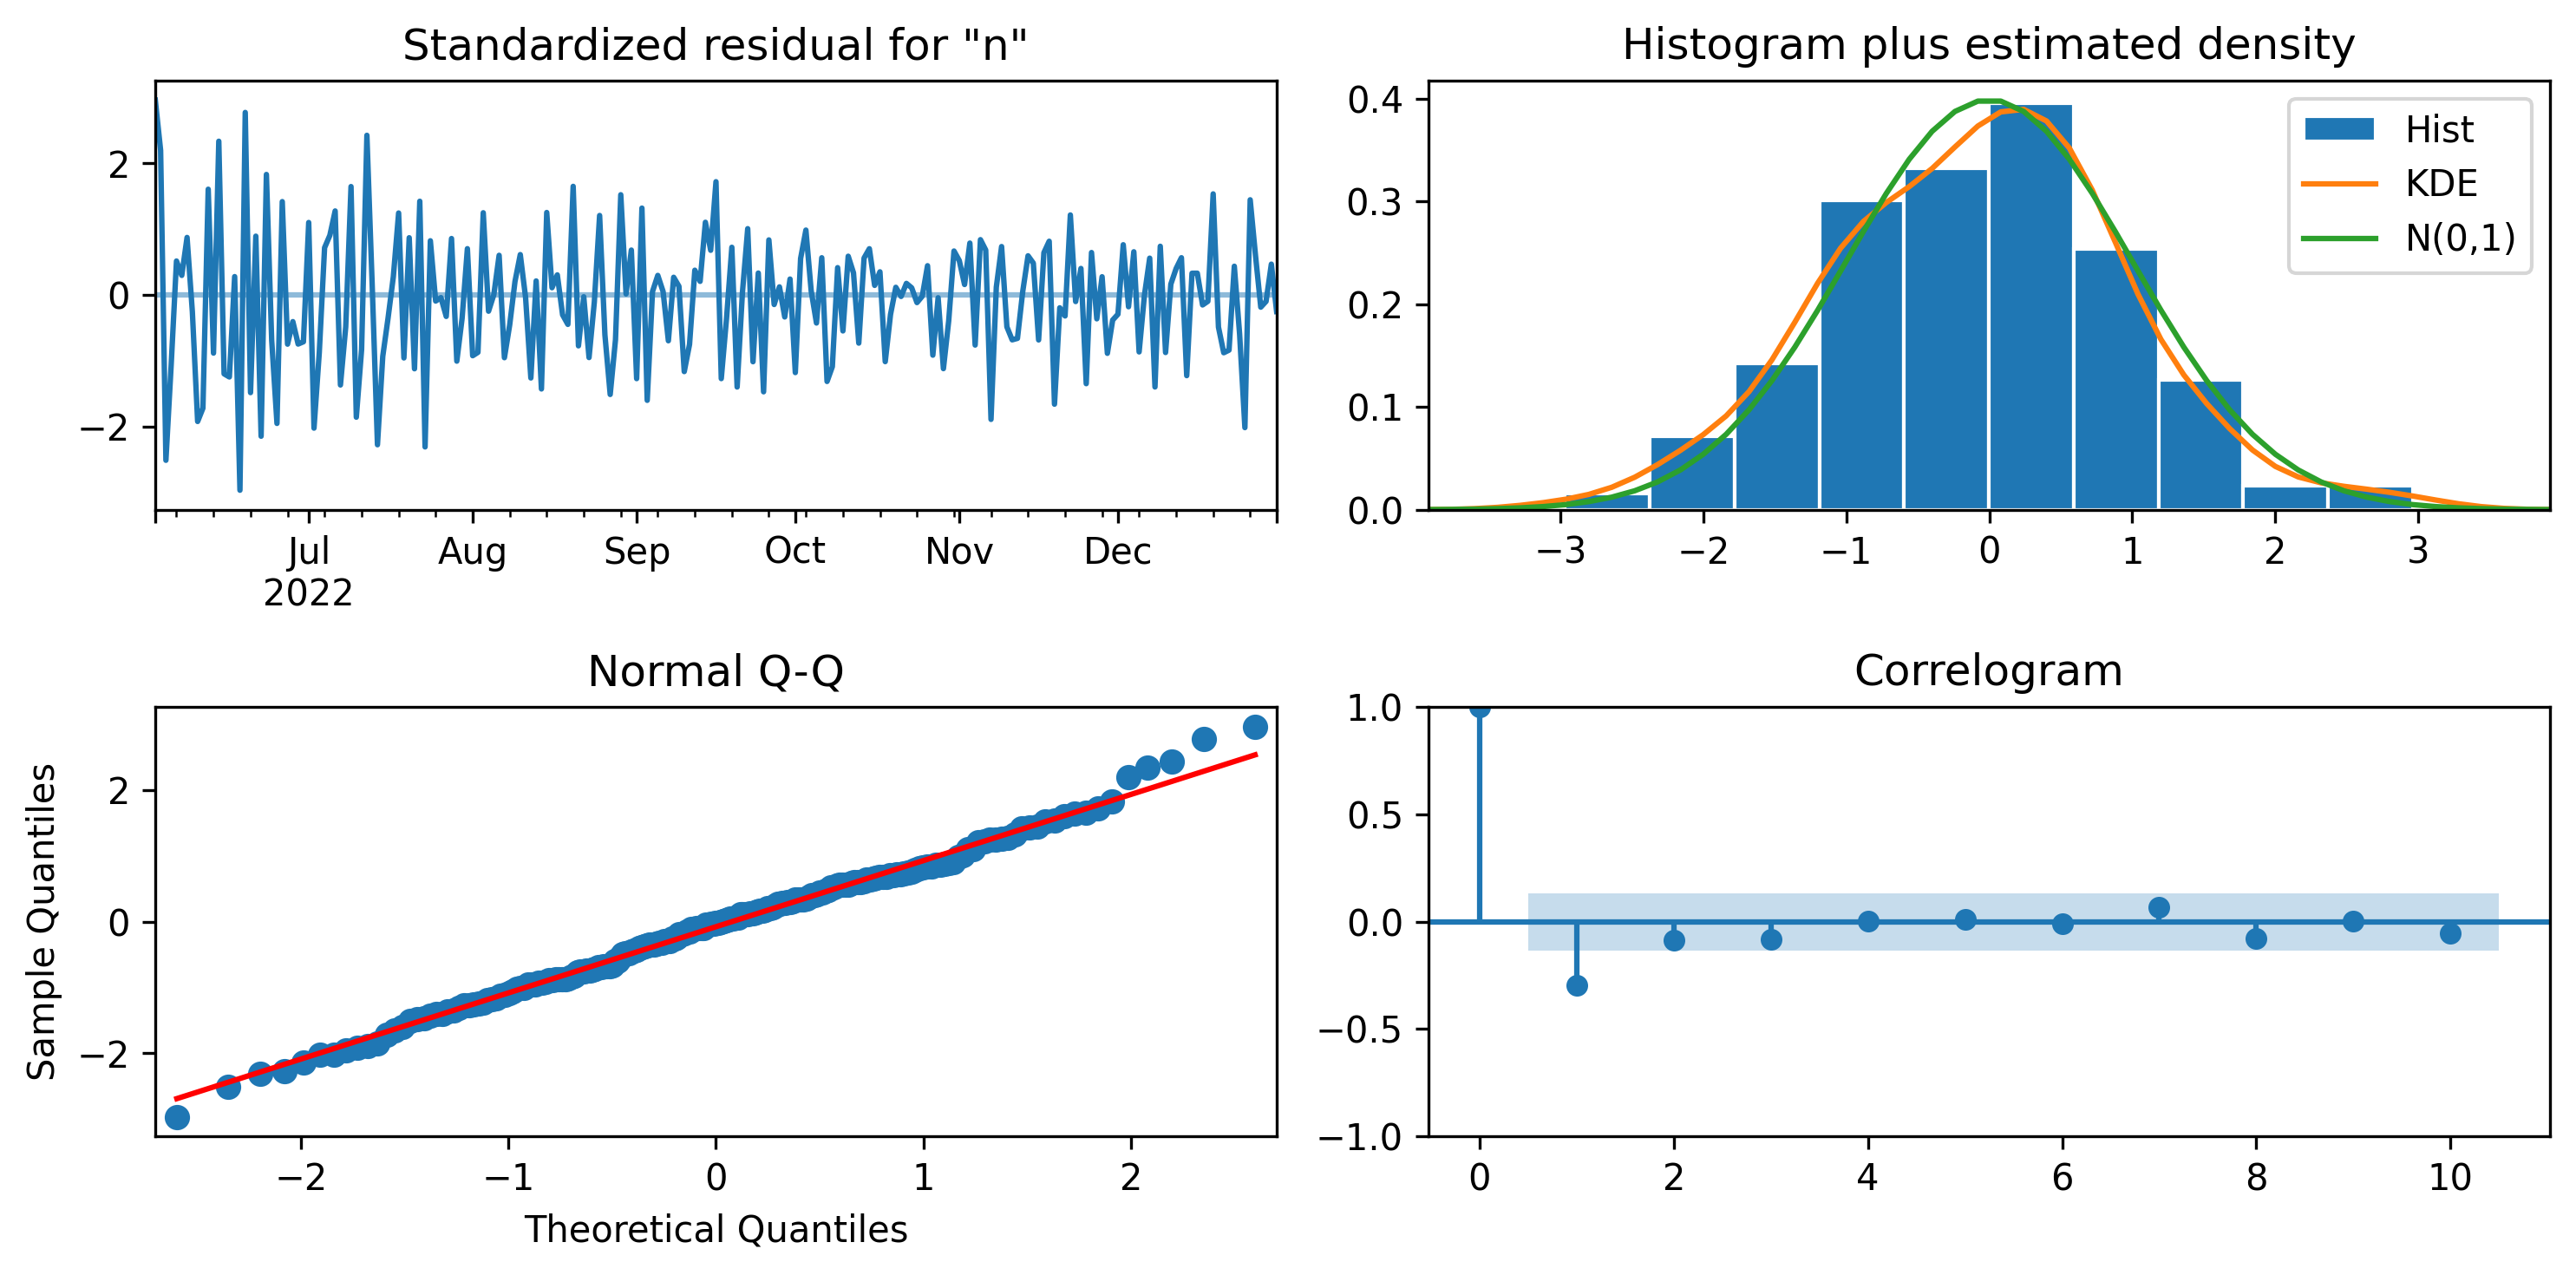

In [37]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), dpi=300)
axes = ax.flatten()
from statsmodels.graphics.utils import _import_mpl, create_mpl_fig

variable=0
lags=10
truncate_endog_names=24
auto_ylims=False
bartlett_confint=False
acf_kwargs=None
        
d = np.maximum(model.loglikelihood_burn, model.nobs_diffuse)
if hasattr(model.data, 'dates') and model.data.dates is not None:
    ix = model.data.dates[d:]
else:
    ix = np.arange(model.nobs - d)
resid = pd.Series(
    model.filter_results.standardized_forecasts_error[variable, d:],
    index=ix)

# Top-left: residuals vs time
ax = axes[0]
resid.dropna().plot(ax=ax)
ax.hlines(0, ix[0], ix[-1], alpha=0.5)
ax.set_xlim(ix[0], ix[-1])
name = model.model.endog_names[variable]
if len(name) > truncate_endog_names:
    name = name[:truncate_endog_names - 3] + '...'
ax.set_title(f'Standardized residual for "{name}"')

# Top-right: histogram, Gaussian kernel density, Normal density
# Can only do histogram and Gaussian kernel density on the non-null
# elements
resid_nonmissing = resid.dropna()
ax = axes[1]
ax.hist(resid_nonmissing, density=True, label='Hist',
        edgecolor='#FFFFFF')

from scipy.stats import gaussian_kde, norm
kde = gaussian_kde(resid_nonmissing)
xlim = (-1.96*2, 1.96*2)
x = np.linspace(xlim[0], xlim[1])
ax.plot(x, kde(x), label='KDE')
ax.plot(x, norm.pdf(x), label='N(0,1)')
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Histogram plus estimated density')

# Bottom-left: QQ plot
ax = axes[2]
from statsmodels.graphics.gofplots import qqplot
qqplot(resid_nonmissing, line='s', ax=ax)
ax.set_title('Normal Q-Q')

# Bottom-right: Correlogram
ax = axes[3]
from statsmodels.graphics.tsaplots import plot_acf

if acf_kwargs is None:
    acf_kwargs = {}
plot_acf(resid, ax=ax, lags=lags, auto_ylims=auto_ylims,
         bartlett_confint=bartlett_confint, **acf_kwargs)
ax.set_title('Correlogram')
plt.tight_layout()

In [38]:
df2.index = pd.to_datetime(df2.date)
df2

,date,numbers,numbers.1
date,,,
2022-06-01,2022-06-01,63241.0,473.0
2022-06-02,2022-06-02,61278.0,-1963.0
2022-06-03,2022-06-03,65431.0,4153.0
2022-06-04,2022-06-04,58263.0,-7168.0
2022-06-05,2022-06-05,56738.0,-1525.0
...,...,...,...
2022-12-27,2022-12-27,20879.0,868.0
2022-12-28,2022-12-28,20160.0,-719.0
2022-12-29,2022-12-29,20001.0,-159.0


In [40]:
predictions = model.get_prediction(start='2022-06-01', end='2023-03-01')
df2_after = df2.copy()
df2_after = df2_after.reindex(predictions.predicted_mean.index)
df2_after['pred_mean'] = predictions.predicted_mean
df2_after['pred_lower_conf'] = predictions.conf_int()["lower numbers"]
df2_after['pred_upper_conf'] = predictions.conf_int()["upper numbers"]
df2_after = df2_after[1:]
df2_after

,date,numbers,numbers.1,pred_mean,pred_lower_conf,pred_upper_conf
2022-06-02,2022-06-02,61278.0,-1963.0,53933.855512,49073.368470,58794.342554
2022-06-03,2022-06-03,65431.0,4153.0,59993.597372,55144.905576,64842.289168
2022-06-04,2022-06-04,58263.0,-7168.0,64475.431365,59627.102548,69323.760182
2022-06-05,2022-06-05,56738.0,-1525.0,59354.935595,54506.617991,64203.253199
2022-06-06,2022-06-06,58478.0,1740.0,57197.971012,52349.653754,62046.288270
...,...,...,...,...,...,...
2023-02-25,NaT,NaN,NaN,20488.964941,-9541.183534,50519.113417
2023-02-26,NaT,NaN,NaN,20488.964941,-9805.902190,50783.832073
2023-02-27,NaT,NaN,NaN,20488.964941,-10068.327667,51046.257550
2023-02-28,NaT,NaN,NaN,20488.964941,-10328.518548,51306.448430


In [41]:
dates = df2_after.index
dates

DatetimeIndex(['2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
               '2022-06-10', '2022-06-11',
               ...
               '2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23',
               '2023-02-24', '2023-02-25', '2023-02-26', '2023-02-27',
               '2023-02-28', '2023-03-01'],
              dtype='datetime64[ns]', length=273, freq='D')

In [42]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=df2_after.numbers, mode='lines', name='Real data (train)'))
fig.add_trace(go.Scatter(x=dates_real, y=real.numbers, mode='lines', name='Real data (test)'))
fig.add_trace(go.Scatter(x=dates, y=df2_after.pred_mean, mode='lines', name='ARIMA prediction'))

# # 添加置信区间带
fig.add_trace(
    go.Scatter(
        name='Upper Bound',
        x=dates,
        y=df2_after.pred_upper_conf,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False)
)
fig.add_trace(
    go.Scatter(
        name='Lower Bound',
        x=dates,
        y=df2_after.pred_lower_conf,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
)

fig.update_layout(title='Time Series Plot with Confidence Interval',
                   xaxis_title='Date',
                   yaxis_title='# of reported results', 
                 legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="center",
                    x=0.5,), 
                  font=dict(
                      size=16
                  )
                 )
fig.add_annotation(
    x="2023-03-01",
    y=20479,
    text="Prediction: 20479 / Real: 19655",
    showarrow=True,
    xanchor="right",
)
fig.show()

In [43]:
pio.write_image(fig, '2.pdf',scale=5, width=1600, height=800)